# 预测建模
北京市空气质量指数预测（推荐难度系数10）

这个数据集是北京市2022年11月1日至2023年10月31日期间空气质量相关数据。
根据这个数据集，回答以下问题

In [2]:
import os
import sys

#导入基础包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from calculate import *
from heatmap import *
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.font_manager as fm
font_path = '/System/Library/Fonts/STHeiti Light.ttc'  # 替换为实际可用的字体文件路径
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

# 导入主成分分析相关包
from factor_analyzer import Rotator
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 导入SARIMA相关包
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 导入XGBOOST相关包
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from matplotlib.dates import DateFormatter, HourLocator

# 导入单独写的函数
from calculate import *
from heatmap import *
from sort_matrix import *

In [16]:
# 设置字体
if sys.platform == 'darwin':  # macOS
    font_path = '/System/Library/Fonts/STHeiti Light.ttc'
elif sys.platform == 'win32': # Windows
    plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统自带黑体
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
else: # Linux/其他系统
    font_path = '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc'  # 文泉驿字体

# 仅非Windows系统需要加载字体文件
if sys.platform != 'win32':
    try:
        font_prop = fm.FontProperties(fname=font_path)
        plt.rcParams['font.family'] = font_prop.get_name()
    except:
        print(f"警告：{font_path} 字体加载失败，请检查路径有效性")
# 读取数据
data=pd.read_excel('北京市空气质量指数与气象数据.xlsx')
data.head()

try:
    os.mkdir('./images')
except FileExistsError:
    pass

## 题目1
研究单日内空气质量指数与各项指标的变化趋势，这种趋势是否具有周期性？

In [17]:
# 数据预处理：将数据按小时分组，计算每个小时各指标的平均值
# 转换Excel日期序列值为实际日期并分组
data['datetime'] = pd.to_datetime(data['date']) + pd.to_timedelta(data['hour'], unit='h')
valid_hours = sorted(data['hour'].unique())
hourly_data = data.groupby('hour').mean().loc[valid_hours]
plt.figure(figsize=(12, 8))
indicators = ['AQI', 'PM2.5', 'PM10', 'CO', 'NO2', 'O3','SO2']
colors = ['#2d87bb', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#ffbb78', '#98df8a', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#ffbb78', '#98df8a', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#ffbb78', '#98df8a', '#d62728',]

normalized = (hourly_data[indicators] - hourly_data[indicators].mean(axis=0)) / hourly_data[indicators].std(axis=0)


<Figure size 1200x800 with 0 Axes>

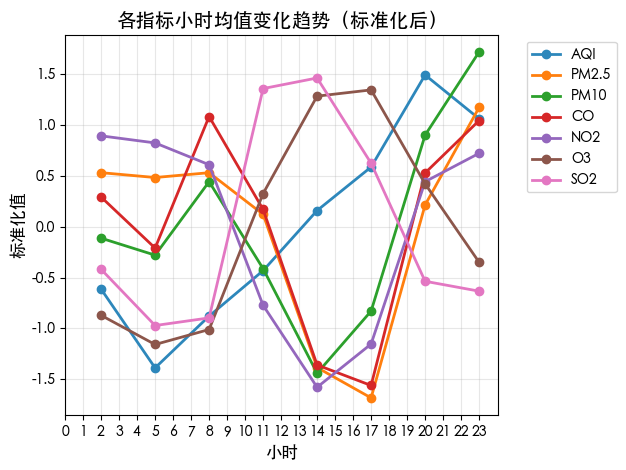

In [18]:
# 绘制各指标小时均值变化趋势（标准化后）折线图
for i, indicator in enumerate(indicators):
    plt.plot(normalized.index, normalized[indicator], 
             marker='o',label=indicator, color=colors[i], linewidth=2)

plt.title('各指标小时均值变化趋势（标准化后）', fontsize=14)
plt.xlabel('小时', fontsize=12)
plt.ylabel('标准化值', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# 新增保存代码
plt.savefig('images/hourly_trends_combined.png', dpi=300, bbox_inches='tight')  # 保存组合大图
plt.show()

# 新增保存子图代码
for i, indicator in enumerate(indicators):
    plt.figure(figsize=(8, 5))
    plt.plot(normalized.index, normalized[indicator], 
             marker='o', color=colors[i], linewidth=2)
    plt.title(f'{indicator}小时均值变化趋势（标准化后）')
    plt.xlabel('小时')
    plt.ylabel('标准化值')
    plt.xticks(range(0, 24))
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'images/hourly_{indicator}.png', dpi=300)  # 保存单个指标子图
    plt.close()

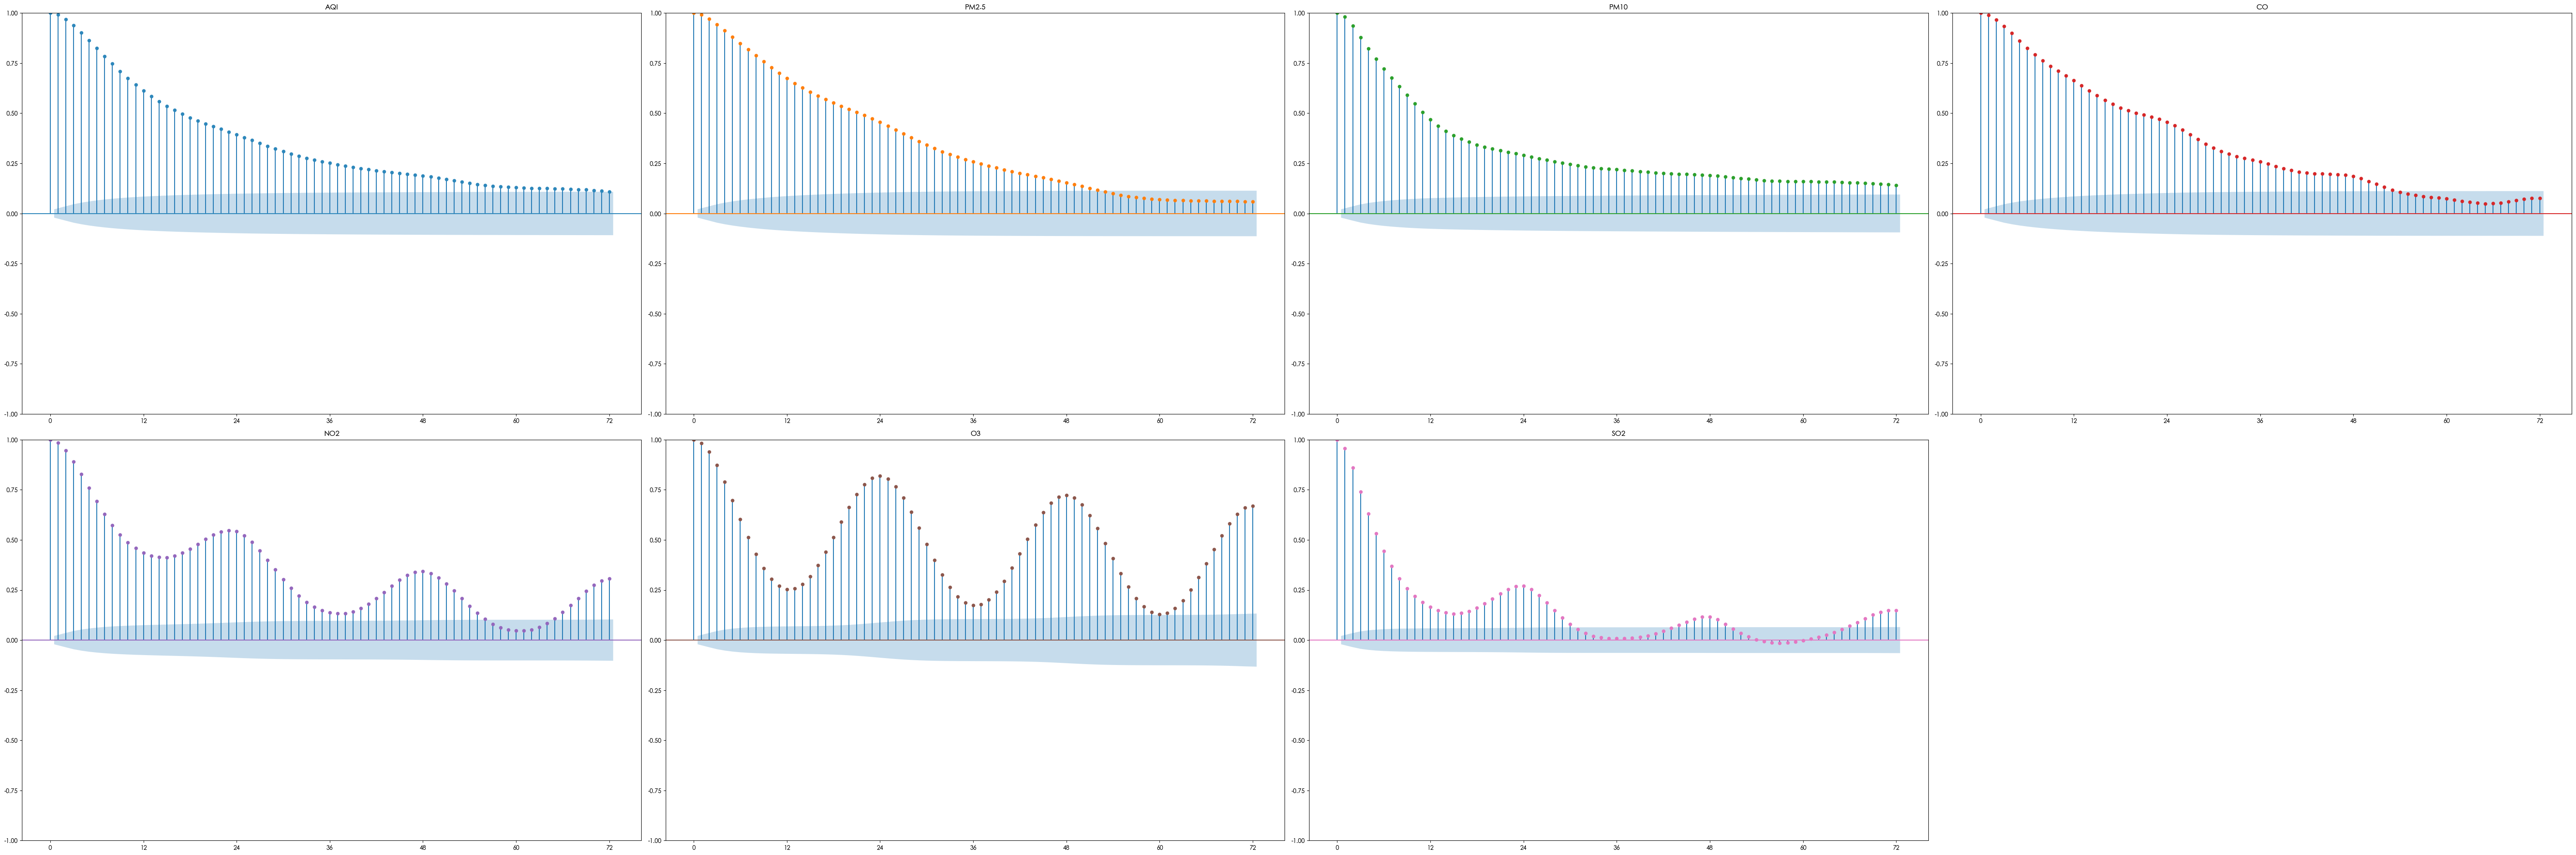

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [19]:
# ACF检验周期性
# 创建完整时间序列（每小时一个样本，缺失值用线性插值）
full_idx = pd.date_range(start=data['datetime'].min(),
                         end=data['datetime'].max(),
                         freq='h')
full_series = data.set_index('datetime').reindex(full_idx)
interpolated = full_series[indicators].interpolate(method='time')

# 绘制ACF图，检验3天周期（24*3）
plt.figure(figsize=(60, 20))  # 调整整体画布尺寸
for i, indicator in enumerate(indicators):
    ax = plt.subplot(2, 4, i+1)  # 创建2行4列的子图布局
    plot_acf(interpolated[indicator].dropna(),
             lags=72,
             alpha=0.05,
             title=f'{indicator}',
             color=colors[i],
             ax=ax)
    plt.xticks(np.arange(0, 73, 12))
plt.tight_layout()
plt.savefig('./images/all_acf_subplots.png', dpi=200, bbox_inches='tight')
plt.show()

for i, indicator in enumerate(indicators):
    plt.figure(figsize=(12, 6))
    plot_acf(interpolated[indicator].dropna(),
             lags=72,
             alpha=0.05,
             title=f'{indicator} ACF',
             color=colors[i])
    plt.xticks(np.arange(0, 73, 12))
    plt.savefig(f'./images/acf_{indicator}.png', dpi=200, bbox_inches='tight')
    plt.close()




## 题目2
简述各项指标间的相互关系。

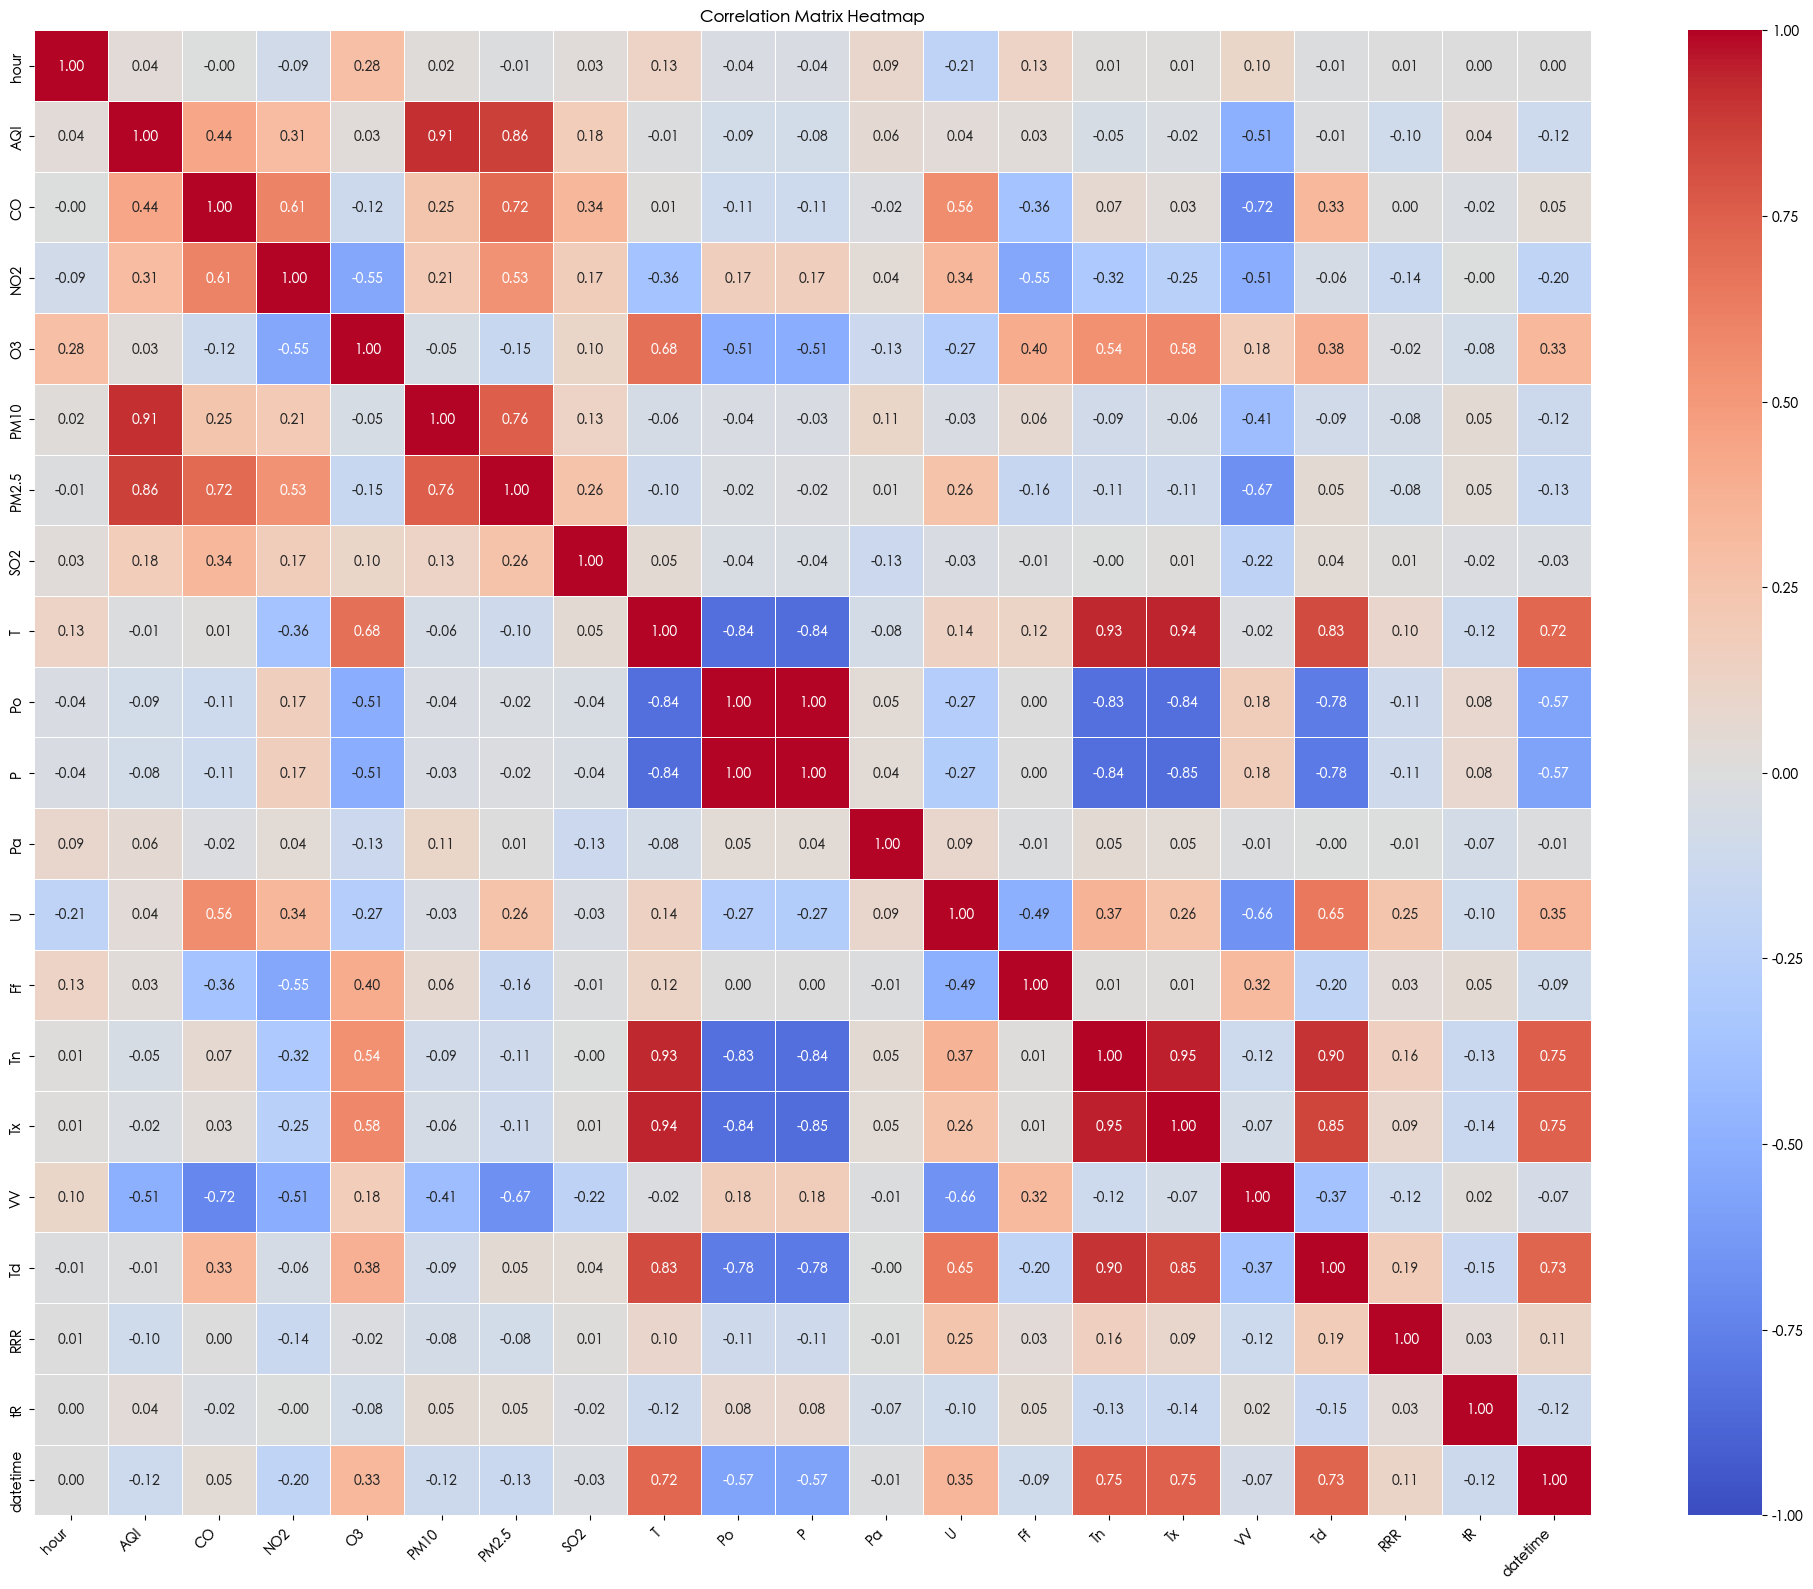

In [20]:
#计算相关系数矩阵
correlation_matrix = data.iloc[:, 1:].corr()
#绘制热力图
plot_heatmap(correlation_matrix,20,16,title="Correlation Matrix Heatmap",save_path="./images/correlation_heatmap.png")

KMO值: 0.762
巴赫利特检验卡方值: 90424.712, p值: 0.0
数据适合进行主成分分析 

累计方差解释比例: ['31.41%', '54.60%', '66.53%', '73.02%', '78.89%', '84.04%', '88.27%', '91.46%', '93.59%', '95.70%', '97.14%', '98.29%', '98.91%', '99.26%', '99.55%', '99.79%', '99.96%', '100.00%', '100.00%']


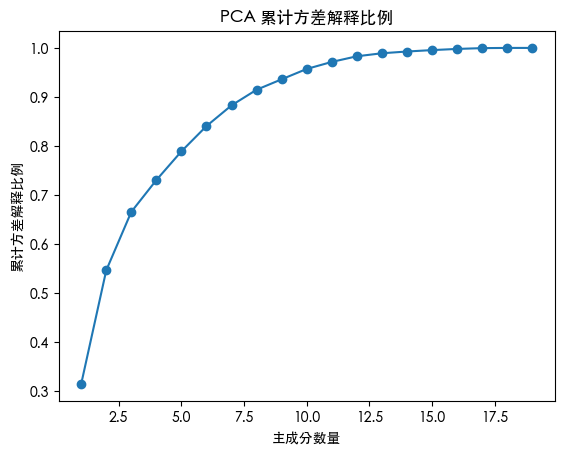

旋转后的载荷矩阵（排序后）：
        Factor1  Factor3  Factor2  Factor4  Factor5
Tn      -0.963    0.035    0.071   -0.079    0.035
T       -0.958   -0.138    0.033    0.074   -0.028
Tx      -0.954   -0.014    0.045   -0.052   -0.063
P        0.924   -0.029    0.071   -0.032   -0.000
Po       0.921   -0.029    0.073   -0.033   -0.000
Td      -0.898    0.366    0.043   -0.013    0.076
O3      -0.637   -0.529   -0.030    0.239   -0.084
U       -0.322    0.824   -0.008   -0.156    0.229
Ff      -0.045   -0.772   -0.126    0.024    0.172
NO2      0.300    0.728   -0.290    0.110   -0.202
CO      -0.101    0.695   -0.449    0.298   -0.007
VV       0.153   -0.667    0.531   -0.093   -0.175
AQI     -0.017    0.038   -0.967    0.025   -0.029
PM10     0.037   -0.060   -0.933   -0.092    0.003
PM2.5    0.049    0.359   -0.879    0.149   -0.007
Pa       0.006    0.055   -0.147   -0.747   -0.130
SO2     -0.035    0.099   -0.208    0.694   -0.065
RRR     -0.139    0.094    0.103   -0.077    0.819
tR       0.163 

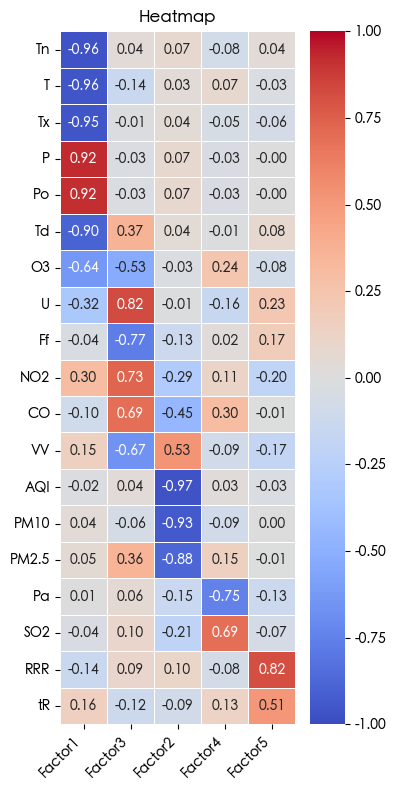

In [21]:
#主成分分析（PCA)
data=pd.read_excel('北京市空气质量指数与气象数据.xlsx')
PCA_data=data.iloc[:,2:]#去除日期列

# 计算KMO值
kmo_all, kmo_model = calculate_kmo(PCA_data)
print(f"KMO值: {kmo_model.round(3)}")
# 进行巴赫利特检验
chi_square_value, p_value = calculate_bartlett_sphericity(PCA_data)
print(f"巴赫利特检验卡方值: {chi_square_value.round(3)}, p值: {p_value}")
#判断
if kmo_model>0.7 and p_value<0.05:
    print("数据适合进行主成分分析",'\n')
else:
    print("数据不适合进行主成分分析",'\n')

# 数据标准化
scaled_data = (PCA_data - PCA_data.mean()) / PCA_data.std()
scaled_data = scaled_data.dropna()#去除空值

# 计算协方差矩阵
cov_matrix = np.cov(scaled_data, rowvar=False)

# 计算特征值和特征向量
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# 绘制累计方差解释比例图
explained_variance_ratio = sorted_eigenvalues / np.sum(sorted_eigenvalues)
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
print("累计方差解释比例:", [f"{cum * 100:.2f}%" for cum in cumulative_explained_variance])

plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('主成分数量')
plt.ylabel('累计方差解释比例')
plt.title('PCA 累计方差解释比例')
plt.savefig('./images/PCA_cumulative_explained_variance.png', dpi=200, bbox_inches='tight')
plt.show()

# 选择特征值大于1的作为主成分
mask = sorted_eigenvalues > 1
selected_eigenvectors = sorted_eigenvectors[:, mask]

# 计算因子载荷矩阵
loadings = selected_eigenvectors * np.sqrt(sorted_eigenvalues[mask])

# 使用Varimax旋转载荷矩阵
rotator = Rotator(method='varimax')
rotated_loadings = rotator.fit_transform(loadings)

# 输出旋转后的成分矩阵
rotated_components_df = pd.DataFrame(rotated_loadings,
                                     index=PCA_data.columns,
                                     columns=[f'Factor{i+1}' for i in range(rotated_loadings.shape[1])])
rotated_components_df = rotated_components_df.round(3)

# 输出排序后的载荷矩阵
rotated_components_df=sort_matrix_by_diag(rotated_components_df)
print("旋转后的载荷矩阵（排序后）：\n", rotated_components_df)
plot_heatmap(rotated_components_df, 4, 8,save_path="./images/components_heatmap.png")

## 题目3
令2022年11月1日至2023年9月30日的空气质量数据为训练集，剩余数据为测试集。基于训练集，尝试使用两种不同的方法构建空气质量指数预测模型，并在测试集上测试。比较所选模型的预测效果。

In [22]:
#重新读取数据
data=pd.read_excel('北京市空气质量指数与气象数据.xlsx')
# 合并 date 和 hour 为新的 data_hour 列
data['data_hour'] = pd.to_datetime(data['date']) + pd.to_timedelta(data['hour'], unit='h')
# 设置 data_hour 为索引列
data = data[['data_hour', 'AQI']].set_index('data_hour')  # 仅保留时间和AQI

### (1)SARIMA模型


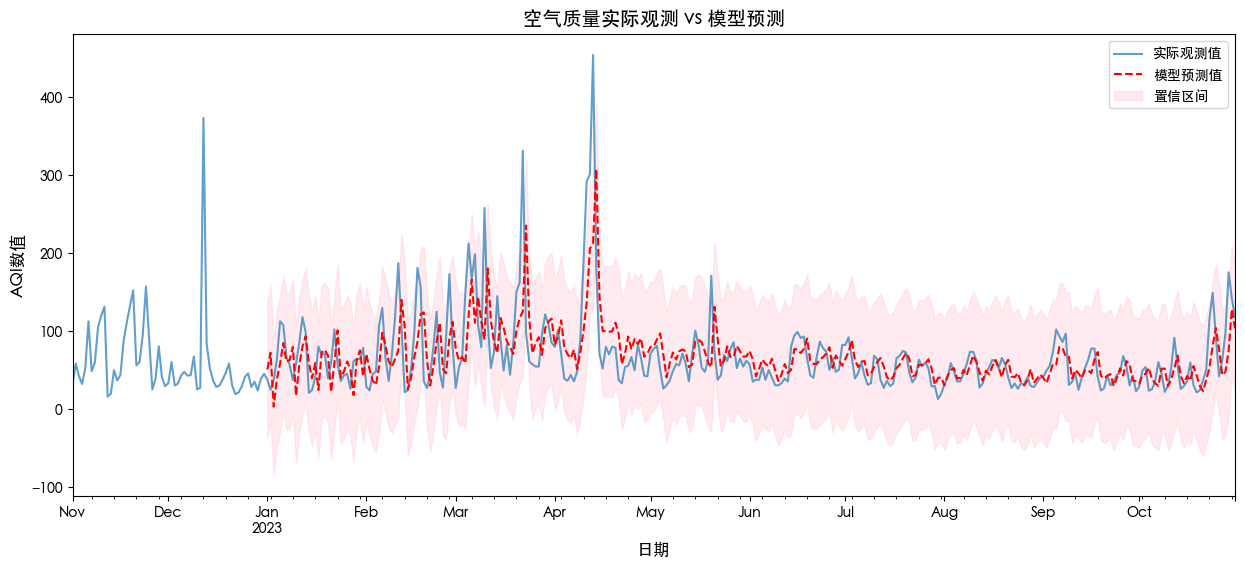

模型拟合度评估:
R² = 0.354
RMSE = 39.860
MAE = 25.894


In [13]:
"""
该模型在假设不知道测试集其他指标的情况下，仅使用AQI历史数据预测未来AQI
"""

data=pd.read_excel('北京市空气质量指数与气象数据.xlsx')
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
# 确保数据按时间排序
ts = data['AQI'].resample('D').mean()  # 按天重采样
ts = ts.bfill() # 处理缺失值

# SARIMA模型训练
model = SARIMAX(ts,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 7))
results = model.fit(disp=False)

# 生成预测结果（包含样本内拟合）
forecast = results.get_prediction(start=pd.to_datetime('2023-01-01'), dynamic=False)
forecast_mean = forecast.predicted_mean
confidence_int = forecast.conf_int()

# 可视化对比
fig, ax = plt.subplots(figsize=(15,6))
ts.plot(ax=ax, label='实际观测值', alpha=0.7)
forecast_mean.plot(ax=ax, style='--', label='模型预测值', color='red')
ax.fill_between(confidence_int.index,
                confidence_int.iloc[:, 0],
                confidence_int.iloc[:, 1], color='pink', alpha=0.3, label='置信区间')

ax.set_title('空气质量实际观测 vs 模型预测', fontsize=14)
ax.set_xlabel('日期', fontsize=12)
ax.set_ylabel('AQI数值', fontsize=12)
plt.legend()
plt.savefig('./images/AQI.png', dpi=200, bbox_inches='tight')
plt.show()

# 计算拟合度指标
from sklearn.metrics import r2_score, mean_squared_error

# 获取实际值和预测值的交集
y_actual = ts[forecast_mean.index]
y_pred = forecast_mean

# 计算评估指标
r2 = r2_score(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mae = mean_absolute_error(y_actual, y_pred)

print(f'''模型拟合度评估:
R² = {r2:.3f}
RMSE = {rmse:.3f}
MAE = {mae:.3f}''')



### (2)XGBOOST模型

In [24]:
"""
该模型在假设不考虑测试集其他指标的情况下，仅使用AQI数据对未来AQI进行<单步预测>，即每次预测都是根据之前时间点的真实AQI值进行的。
整体运行时间约为20s，请耐心等待。
"""
#特征工程
data_processed = data.copy()

#时间分解特征
# 基础特征
data_processed['hour'] = data_processed.index.hour
data_processed['day_of_week'] = data_processed.index.dayofweek
data_processed['month'] = data_processed.index.month

# 周期性编码
data_processed['hour_sin'] = np.sin(2 * np.pi * data_processed['hour'] / 24)
data_processed['hour_cos'] = np.cos(2 * np.pi * data_processed['hour'] / 24)
data_processed['week_sin'] = np.sin(2 * np.pi * data_processed['day_of_week'] / 7)
data_processed['week_cos'] = np.cos(2 * np.pi * data_processed['day_of_week'] / 7)

#滞后特征
# 生成3小时粒度的滞后特征（最多7天）
lags = [i for i in range(1, 7 * 8 + 1)]  # 7天*每天8个时间点（3小时间隔）
for lag in lags:
    data_processed[f'AQI_lag_{lag}'] = data_processed['AQI'].shift(lag)

# 划分数据集
train_data = data_processed.loc['2022-11-01':'2023-09-30']
test_data = data_processed.loc['2023-10-01':]

# 特征选择
features = [col for col in train_data.columns if col != 'AQI']
X_train, y_train = train_data[features], train_data['AQI']
X_test, y_test = test_data[features], test_data['AQI']

In [25]:
#随机搜索法参数调优（这里耗时较长，请耐心等待）
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': randint(5, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'gamma': uniform(0, 0.3)
}

search = RandomizedSearchCV(
    XGBRegressor(n_jobs=-1, random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1
)
search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x142527890>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x144aa2de0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x144a6e690>,
                                        'n_estimators': [100, 200, 300],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x144aa1d90>},
                   scoring='neg_mean_absolute_error', verbose=1)

In [26]:
#模型预测
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
#评估指标
metrics=cal_metrics(y_pred, y_test)
#输出结果
print("最佳参数组合：", search.best_params_)
print("评估指标：")
for k, v in metrics.items():
    print(f"{k}: {v:.2f}")

最佳参数组合： {'colsample_bytree': 0.901544465464015, 'gamma': 0.179916517642253, 'learning_rate': 0.0342954642051878, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8476270714159938}
评估指标：
RMSE: 11.54
R-squared: 0.93
MAE: 7.42


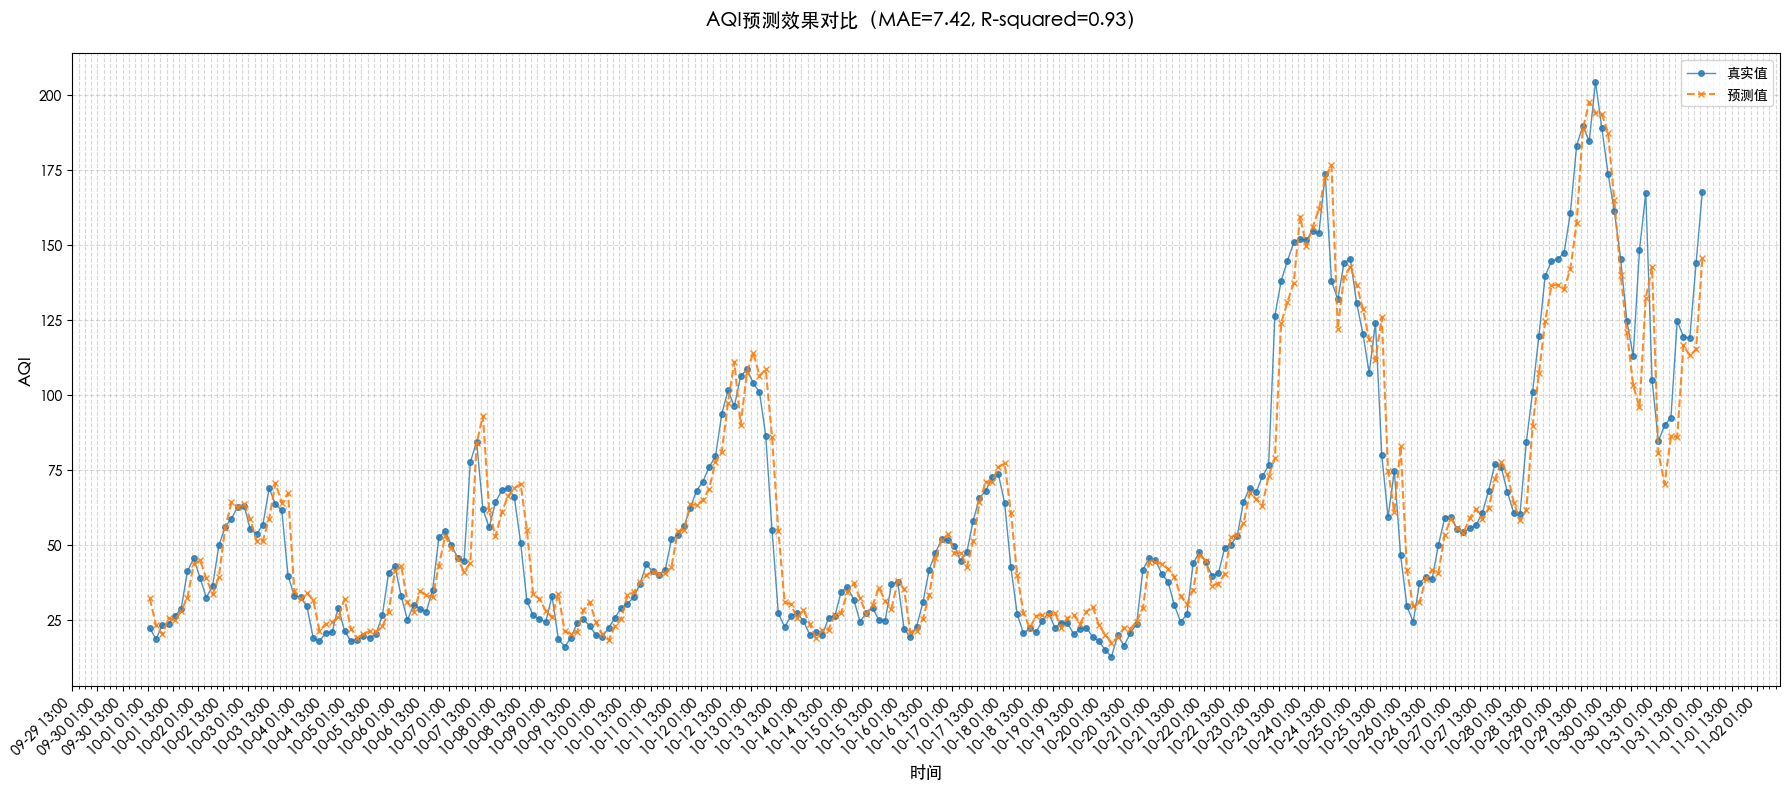

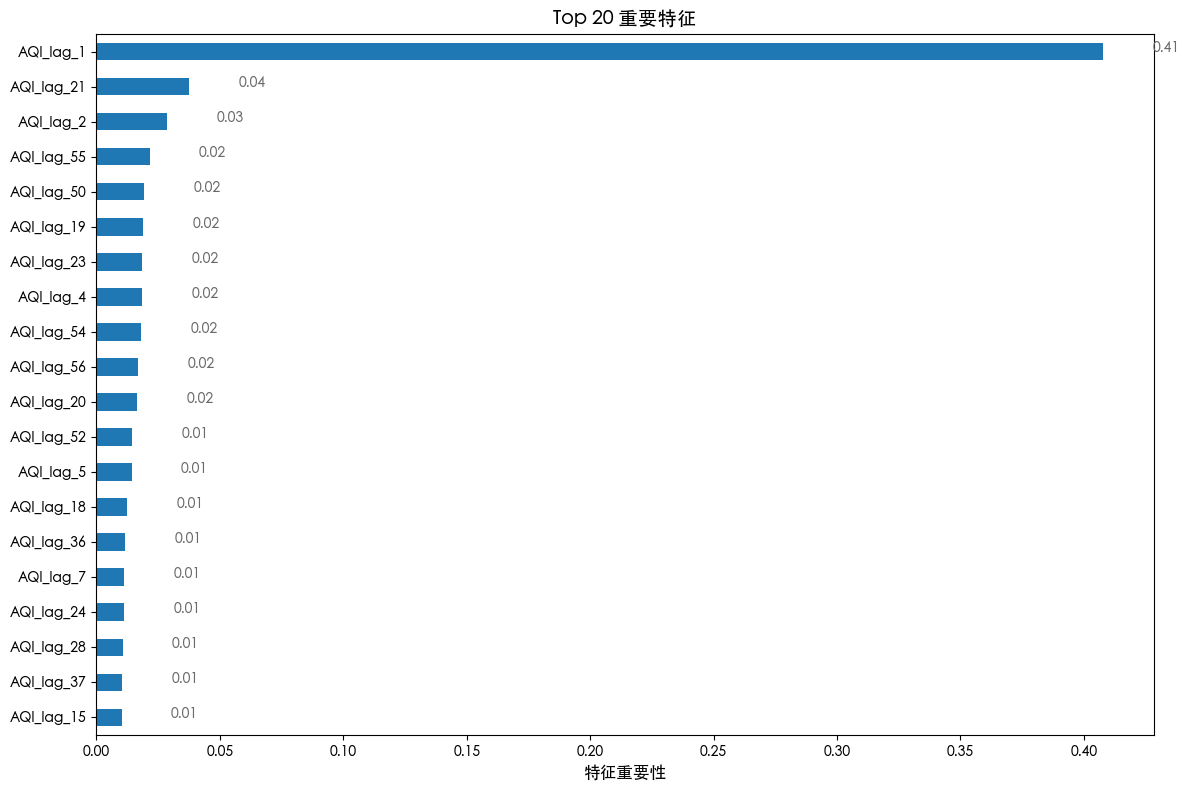

In [27]:
#预测结果可视化
def plot_results(y_true, y_pred, timestamps):
    plt.figure(figsize=(18, 8))
    ax = plt.gca()

    # 绘制预测曲线
    ax.plot(timestamps, y_true, label='真实值',
            marker='o', markersize=4, linewidth=1, alpha=0.8)
    ax.plot(timestamps, y_pred, label='预测值',
            linestyle='--', marker='x', markersize=5, alpha=0.9)

    # 设置时间轴格式
    ax.xaxis.set_major_locator(HourLocator(interval=12))
    ax.xaxis.set_minor_locator(HourLocator(interval=3))
    ax.xaxis.set_major_formatter(DateFormatter("%m-%d %H:%M"))

    # 增强可视化元素
    plt.title(f'AQI预测效果对比（MAE={metrics["MAE"]:.2f}, R-squared={metrics["R-squared"]:.2f}）',
              fontsize=14, pad=20)
    plt.xlabel('时间', fontsize=12)
    plt.ylabel('AQI', fontsize=12)
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()

    # 自动调整标签
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('./images/xg_by_step.png', dpi=200, bbox_inches='tight')
    plt.show()

plot_results(y_test, y_pred, test_data.index)

#特征重要性可视化
def plot_importance(model, features, top_n=20):
    importance = pd.Series(model.feature_importances_, index=features)
    top_features = importance.sort_values(ascending=False)[:top_n]

    plt.figure(figsize=(12, 8))
    ax = top_features.sort_values().plot.barh()

    # 添加数据标签
    for i in ax.patches:
        ax.text(i.get_width() + 0.02, i.get_y() + 0.2,
                f'{i.get_width():.2f}',
                fontsize=10, color='dimgrey')

    plt.title('Top {} 重要特征'.format(top_n), fontsize=14)
    plt.xlabel('特征重要性', fontsize=12)
    plt.tight_layout()
    plt.savefig('./images/xg_feature_importance.png', dpi=200, bbox_inches='tight')
    plt.show()


plot_importance(best_model, features)